# Italy - nation, regions and provinces growth rate distribution comparison

In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta,datetime
import random
random.seed(3)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import scipy.stats as ss
import json
import warnings
warnings.filterwarnings("ignore")

/Users/fionaguo/.pyenv/versions/3.7.8/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [14]:
# data import - provinces stops at June 30
provinces_raw = pd.read_csv("italy_covid19_province.csv")
provinces_raw["province"] = provinces_raw["region"] + " " + provinces_raw["province"]
provinces_raw.drop(["region","region_code","province_code"],axis=1,inplace=True)
provinces_raw["date"] = pd.to_datetime(provinces_raw["date"]).dt.date
provinces_raw = provinces_raw[provinces_raw["date"] <= pd.Timestamp("2020-05-31")]

provinces_lst = pd.unique(provinces_raw["province"])
provinces = {}
arrival_p = pd.Series()
for p in provinces_lst:
    temp = provinces_raw[provinces_raw["province"]==p]
    temp["di_cases"] = temp["cases"].diff()
    temp.loc[temp["di_cases"]<0,"di_cases"] = 0
    temp = temp[1:].reset_index(drop=True)
    temp["diff_time"] = (temp["date"] - datetime(2020,1,1).date()).dt.days
    # arrival date
    infection_dates = temp.loc[temp["cases"]!=0,'diff_time']
    if len(infection_dates) > 0:
        arrival_date = infection_dates.iloc[0]
    arrival_p[p] = arrival_date
#     temp = temp[arrival_date:]
#     temp = temp.reset_index(drop=True)
    provinces[p] = temp

In [4]:
provinces_raw

,date,province,cases
0,2020-02-24,Abruzzo L'Aquila,0
1,2020-02-24,Abruzzo Teramo,0
2,2020-02-24,Abruzzo Pescara,0
3,2020-02-24,Abruzzo Chieti,0
4,2020-02-24,Abruzzo Undefined,0
...,...,...,...
12539,2020-05-31,Veneto Treviso,2658
12540,2020-05-31,Veneto Venezia,2661
12541,2020-05-31,Veneto Padova,3932
12542,2020-05-31,Veneto Rovigo,442


In [15]:
# data import - regions
regions_raw = pd.read_csv("italy_covid19_region.csv")
regions_raw["date"] = pd.to_datetime(regions_raw["date"]).dt.date
regions_raw = regions_raw[regions_raw["date"]<=pd.Timestamp("2020-05-31")]

regions_lst = pd.unique(regions_raw["region"])
regions = {}
arrival_r = pd.Series()
for r in regions_lst:
    temp = regions_raw[regions_raw["region"]==r]
    temp["di_cases"] = temp["cases"].diff()
    temp["di_deaths"] = temp["deaths"].diff()
    temp.loc[temp["di_cases"]<0,"di_cases"] = 0
    temp.loc[temp["di_deaths"]<0,"di_deaths"] = 0
    temp["diff_time"] = (temp["date"] - datetime(2020,1,1).date()).dt.days
    temp = temp[1:].reset_index(drop=True)
    # arrival date
    infection_dates = temp.loc[temp["cases"]!=0,'diff_time']
    if len(infection_dates) > 0:
        arrival_date = infection_dates.iloc[0]
    arrival_r[r] = arrival_date
    regions[r] = temp

In [5]:
nation = regions_raw.groupby(["date"]).sum()
nation["di_cases"] = nation["cases"].diff()
nation["di_deaths"] = nation["deaths"].diff()
nation.loc[nation["di_cases"]<0,"di_cases"] = 0
nation.loc[nation["di_deaths"]<0,"di_deaths"] = 0
nation = nation[1:].reset_index()
nation["diff_time"] = (nation["date"] - datetime(2020,1,1).date()).dt.days
nation = nation[nation["date"]<=pd.Timestamp("2020-05-31")]

             date                         province  cases
12465  2020-05-31                 Lombardia Milano  23076
12488  2020-05-31                  Piemonte Torino  15607
12467  2020-05-31                Lombardia Brescia  14768
12466  2020-05-31                Lombardia Bergamo  13366
12469  2020-05-31                Lombardia Cremona   6459
...           ...                              ...    ...
12423  2020-05-31             Basilicata Undefined      0
12485  2020-05-31           P.A. Bolzano Undefined      0
12509  2020-05-31               Sardegna Undefined      0
12420  2020-05-31                Abruzzo Undefined      0
12450  2020-05-31  Friuli Venezia Giulia Undefined      0

[128 rows x 3 columns]
            date                 region  deaths  cases
2045  2020-05-31              Lombardia   16112  88968
2050  2020-05-31               Piemonte    3867  30637
2041  2020-05-31         Emilia-Romagna    4114  27790
2057  2020-05-31                 Veneto    1918  19152
2054 

Text(0.5, 1.0, 'Cumulative counts in Regions as of 2020-05-31')

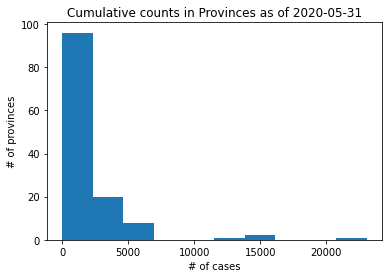

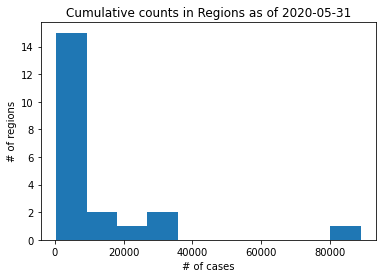

In [87]:
# visualize cumulative counts
p_cumsum_0531 = provinces_raw[provinces_raw["date"]==pd.Timestamp("2020-05-31")]
r_cumsum_0531 = regions_raw[regions_raw["date"]==pd.Timestamp("2020-05-31")]
print(p_cumsum_0531.sort_values("cases",ascending=False))
print(r_cumsum_0531.sort_values("cases",ascending=False))

plt.figure()
plt.hist(p_cumsum_0531["cases"])
plt.xlabel("# of cases")
plt.ylabel("# of provinces")
plt.title("Cumulative counts in Provinces as of 2020-05-31")

plt.figure()
plt.hist(r_cumsum_0531["cases"])
plt.xlabel("# of cases")
plt.ylabel("# of regions")
plt.title("Cumulative counts in Regions as of 2020-05-31")

In [6]:
def pseudoR2(model,mode = "CU"):
    # input: model: a GLM poisson or NB model
    #        mode: "CU" = Nagelkerke / Cragg & Uhler’s; "McFadden"; "ML" = Maximum Likelihood (Cox & Snell)
    L_f = model.llf # log-likelihood of full model
    L_i = model.llnull # log-likelihood of intercept
    N = model.nobs # number of data points
    
    r2McFadden = 1 - L_f/L_i
    G2 = -2 * (L_i - L_f)
    r2ML = 1 - np.exp(-G2/N)
    r2ML_max = 1 - np.exp(L_i * 2/N)
    r2CU = r2ML/r2ML_max
    if mode == "CU":
        r2 = r2CU
    if mode == "McFadden":
        r2 = r2McFadden
    if mode == "ML":
        r2 = r2ML
    if np.isnan(r2):
        r2 = 0
    return r2


In [7]:
def growthRate(data,data_type,var,mode,pR2_mode,poisson_chi2_cutoff,exp_cutoff = True):
    # input: data - dictionary of pd dataframe or a single pd dataframe
    #        data_type = "dict" or "pd_df"
    #        poisson_expr - str
    #        var - variable (column name in pd dataframe) to be regressed on. eg "di_cases","di_deaths","infections"
    #        mode = "Poisson" or "NB"
    #        pR2_mode = "CU" or "McFadden" or "ML"
    #        poisson_chi2_cutoff - int, if chi2 larger than this, discard this data
    
    # initiate statistics to be recorded
    stats = {}
    stats["outlier"] = 0
    stats["fail_poisson"] = 0
    stats["poisson_insig"] = 0
    stats["nb_insig"] = 0
    stats["high_poisson_chi2"] = 0
    stats["poisson_small_p"] = 0
    stats["nb_small_p"] = 0
    
    poisson_expr = var + """ ~ diff_time"""
    ols_expr = """aux_ols ~ y_lambda - 1"""
    
    if data_type == "pd_df":
        temp_data = data.copy()
        data = {}
        data[0] = temp_data
    
    growth_rates = [] 
    intercepts = []
    subregions_used = []
    pRsquared = []
    std_errs = []
    cut_offs = []
    tot_infected = []
    predictions = {}
    nobs = 0
    
    for k,v in data.items():
        df = v.copy()
        df["diff_time"] = np.linspace(0,len(df)-1,len(df))
        Y,X = dmatrices(poisson_expr,df,return_type='dataframe')
        total_infect = np.sum(df[var])
        # exclude the outliers
        if len(df[df[var]!=0]) < 5 or total_infect < 30:
            stats["outlier"] += 1
            continue
        if exp_cutoff:
            # cut off upto exp ends using grid search, use the poisson model with best pseudo R^2 
            day_cnt = 0
            n_infected = 0
            pR2 = 0
            poisson = None
            cut_off = 0
            for i in range(len(df[var])):
                if df[var][i] != 0:
                    day_cnt += 1
                    n_infected += df[var][i]
                if day_cnt >= 5 and n_infected > 30:
                    temp = df[:i+1]
                    y,x = dmatrices(poisson_expr,temp,return_type='dataframe')
                    try:
                        temp_model = sm.GLM(y,x,family=sm.families.Poisson()).fit()
                    except:
                        stats["fail_poisson"] += 1
                        continue
                    temp_pR2 = pseudoR2(temp_model,mode=pR2_mode)
                    if temp_pR2 > pR2:
                        pR2 = temp_pR2
                        poisson = temp_model
                        cut_off = i
                        nobs=len(y)
        else:
            poisson = sm.GLM(Y,X,family=sm.families.Poisson()).fit()
            pR2 = pseudoR2(poisson,mode=pR2_mode)
            cut_off = len(df)
            nobs=len(Y)
        if pR2 == 0 or poisson == None or cut_off == 0:
            stats["poisson_insig"] += 1
            continue
        # check the significance of poisson regression
#         if poisson.pearson_chi2 > poisson_chi2_cutoff: # curves that don't follow exp trend (threshold 210 is inspected by eyes, not sure)
#             stats["high_poisson_chi2"] += 1
#             print(poisson.pearson_chi2)
#             continue
        if mode == "Poisson":
            if pR2 >= 0.3:
                final_model = poisson
                growth_rate = poisson.params["diff_time"]
                intercept = poisson.params["Intercept"]
                pRs = pR2
                std_err = poisson.bse["diff_time"]
            else:
                stats["poisson_small_p"] += 1
                continue
        else:
            # continue to Negative binomial
            df = df[:cut_off+1]
            y,x = dmatrices(poisson_expr,df,return_type='dataframe')
            # auxiliary OLS to fit the alpha in NB2
            df["y_lambda"] = poisson.mu
            df["aux_ols"] = df.apply(lambda x: ((x['di_cases'] - x['y_lambda'])**2 - x['di_cases']) / x['y_lambda'], axis=1)
            aux_olsr = smf.ols(ols_expr,df).fit()
            try:
                nb = sm.GLM(y,x,family=sm.families.NegativeBinomial(alpha=aux_olsr.params[0])).fit()
                nb_pR2 = pseudoR2(nb,mode=pR2_mode)
                if nb_pR2 >= 0:
                    final_model = nb
                    growth_rate = nb.params["diff_time"]
                    intercept = nb.params["Intercept"]
                    pRs = nb_pR2
                    std_err = nb.bse["diff_time"]
                else:
                    stats["nb_small_p"] += 1
                    continue
            except:
                stats["nb_insig"] += 1
                # use poisson result
                if pR2 >= 0.3:
                    final_model = poisson
                    growth_rate = poisson.params["diff_time"]
                    intercept = poisson.params["Intercept"]
                    pRs = pR2
                    std_err = poisson.bse["diff_time"]
                    nobs=len(y)
                else:
                    stats["poisson_small_p"] += 1
                    continue
            
        growth_rates.append(growth_rate)
        intercepts.append(intercept)
        subregions_used.append(k)
        pRsquared.append(pRs)
        std_errs.append(std_err)
        cut_offs.append(cut_off)
        tot_infected.append(total_infect)
        predictions[k] = final_model.predict(X)
        
    results = pd.DataFrame({"Growth Rate":growth_rates,"intercepts":intercepts,"pR2":pRsquared,"std_error":std_errs,"cut_offs":cut_offs,"tot_infected":tot_infected},index=subregions_used)
    return [results,predictions,stats]

In [8]:
# county_state_nation growth rate distribution - infected
p_i_results,p_i_pred,p_stats = growthRate(provinces,"dict","di_cases","NB","McFadden",500)
r_i_results,r_i_pred,r_stats = growthRate(regions,"dict","di_cases","NB","McFadden",500)
n_i_results,n_i_pred,n_stats = growthRate(nation,"pd_df","di_cases","NB","McFadden",500)
print("p_stats",p_stats)
print("r_stats",r_stats)
print("n_stats",n_stats)

p_stats {'outlier': 10, 'fail_poisson': 0, 'poisson_insig': 0, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0}
r_stats {'outlier': 0, 'fail_poisson': 0, 'poisson_insig': 0, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0}
n_stats {'outlier': 0, 'fail_poisson': 0, 'poisson_insig': 0, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0}


In [9]:
# counties_infected_out = counties_infected_results[["Infection Growth Rate","intercepts"]]
# states_infected_out = states_infected_results[["Infection Growth Rate","intercepts"]]
# nation_infected_out = nation_infected_results[["Infection Growth Rate","intercepts"]]
# #counties_infected_out.to_csv("counties_infected_fits.csv")
# #states_infected_out.to_csv("states_infected_fits.csv")
# nation_infected_out

import pickle
# save
Italy = {}
Italy["p"] = p_i_results
Italy["r"] = r_i_results
Italy["n"] = n_i_results

with open("Italy_first_wave_growth_rates.pickle","wb") as f:
    pickle.dump(Italy,f)

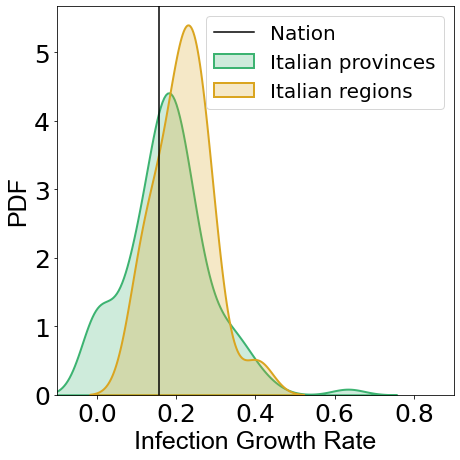

In [42]:
# Infected
p_i_results.loc[p_i_results["Growth Rate"]<0,"Growth Rate"] = 0
# Figure 1(d)
fig = plt.figure(figsize=[6.5,6.5])

# plt.title("Growth Rates Daily Increase of Infected",fontname="Arial", fontsize=15)
# p_c = plt.hist(p_i_results["growth_rates"],color = "blue",alpha = 0.3,density=True,label = "county")
p_c = sns.distplot(p_i_results["Growth Rate"],hist=False, kde=True, 
             bins=40, color = "mediumseagreen",
             kde_kws={'linewidth': 2,"shade": True},label = "Italian provinces")
# p_s = plt.hist(r_i_results["growth_rates"],color="green",alpha = 0.3,density=True,label="state")
p_s = sns.distplot(r_i_results["Growth Rate"], hist=False,kde=True, 
             bins=40, color = "goldenrod",
             kde_kws={'linewidth': 2,"shade": True},label = "Italian regions")
p_n = plt.axvline(x=n_i_results["Growth Rate"][0],color="black",label="Nation")
# p_a_c = plt.axvline(x=county_agg_growth_rate,color="blue",label="county_agg")
# p_a_s = plt.axvline(x=state_agg_growth_rate,color="green",label="state_agg")
plt.legend(fontsize=20)
plt.xlabel("Infection Growth Rate",fontname="Arial", fontsize=25)
plt.ylabel("PDF",fontname="Arial", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim((-0.1,0.9))
plt.tight_layout()


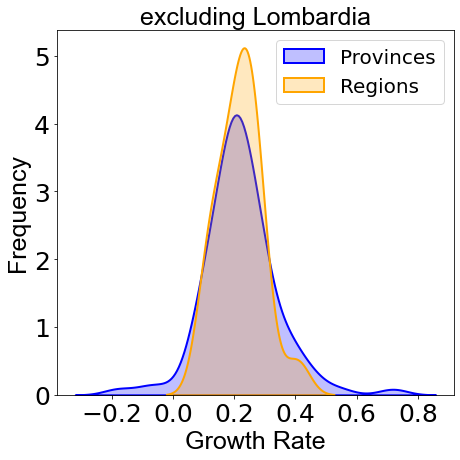

In [142]:
# plot excluding Lombardia
p_wo_Lombar_i_results = p_i_results.loc[p_i_results.index.difference(p_i_results.index[p_i_results.index.str.contains('Lombardia', regex=False)]),]
r_wo_Lombar_i_results = r_i_results.drop("Lombardia",axis=0)

fig = plt.figure(figsize=[6.5,6.5])
plt.xlabel("Growth Rate",fontname="Arial", fontsize=25)
plt.ylabel("Frequency",fontname="Arial", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title("excluding Lombardia",fontname="Arial", fontsize=25)
p_c = sns.distplot(p_wo_Lombar_i_results["Growth Rate"],hist=False, kde=True, 
             bins=40, color = "blue",
             kde_kws={'linewidth': 2,"shade": True},label = "Provinces")
p_s = sns.distplot(r_wo_Lombar_i_results["Growth Rate"], hist=False,kde=True, 
             bins=40, color = "orange",
             kde_kws={'linewidth': 2,"shade": True},label = "Regions")
# p_n = plt.axvline(x=n_i_results["Growth Rate"][0],color="black",label="Nation")
plt.legend(fontsize=20)
plt.tight_layout()

In [153]:
p_i_results.sort_values("Growth Rate",ascending=False)[40:90]


,Growth Rate,intercepts,pR2,std_error,cut_offs,tot_infected
Marche Ancona,0.247030,-14.224054,0.699513,0.019224,20,1883.0
Lombardia Sondrio,0.239948,-15.413051,0.342991,0.042521,23,1584.0
Umbria Perugia,0.239392,-14.857520,0.590743,0.021363,25,1014.0
Veneto Verona,0.236964,-13.327938,0.713362,0.015586,22,5131.0
Friuli Venezia Giulia Udine,0.233444,-14.147002,0.409024,0.028179,23,1016.0
Lombardia Monza e della Brianza,0.231423,-13.143204,0.481081,0.019059,25,5774.0
Emilia-Romagna Rimini,0.223092,-11.723550,0.483011,0.022849,17,2194.0
Sardegna Sud Sardegna,0.223088,-16.977155,0.425663,0.048458,31,103.0
Veneto Vicenza,0.222567,-12.720039,0.605653,0.018450,22,2868.0
Piemonte Biella,0.222318,-14.032089,0.355552,0.029701,26,1047.0


([<matplotlib.axis.XTick at 0x1480d4b50>,
 [Text(0, 0, '0225'),
  Text(15, 0, '0311'),
  Text(30, 0, '0326'),
  Text(45, 0, '0410'),
  Text(60, 0, '0425'),
  Text(75, 0, '0510'),
  Text(90, 0, '0525'),
  Text(105, 0, '0609'),
  Text(120, 0, '0624')])

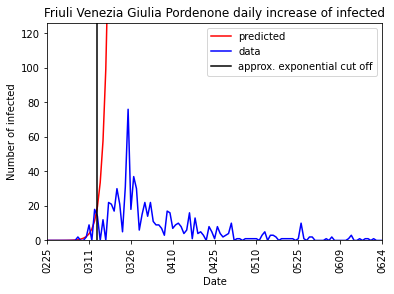

In [147]:
p = "Friuli Venezia Giulia Pordenone"
start_date = pd.to_timedelta(provinces[p]["diff_time"][0],unit="D") + pd.Timestamp('1/1/2020')
dates = pd.date_range(start=start_date,periods = len(provinces[p]["diff_time"]),freq="D")
dates = dates.format(formatter=lambda x: x.strftime('%m%d'))
dates = dates[0::15]

xlim = provinces[p]["di_cases"].max() + 50

plt.figure()
plt.xlim((0,p_i_results["cut_offs"][p]+30))
plt.ylim((0,xlim))
plt.title(p+" daily increase of infected")
plt.plot(p_i_pred[p],color="red",label="predicted")
plt.plot(provinces[p]["di_cases"],color = "blue",label="data")
plt.axvline(x=p_i_results["cut_offs"][p],color="black",label="approx. exponential cut off")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Number of infected")
plt.xticks(ticks = range(0,len(provinces[p]["di_cases"]),15),labels=dates,rotation=90)

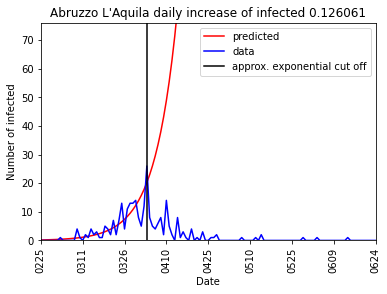

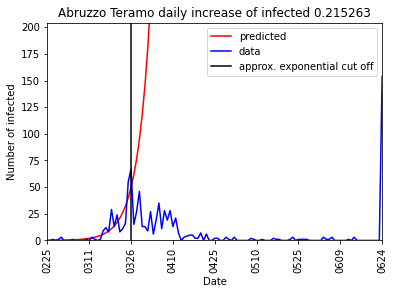

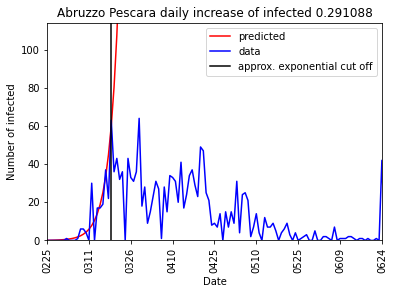

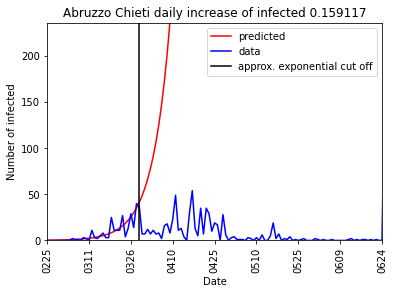

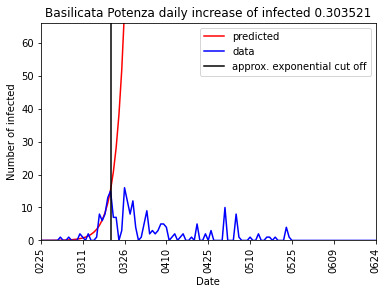

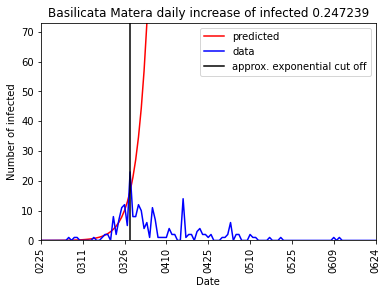

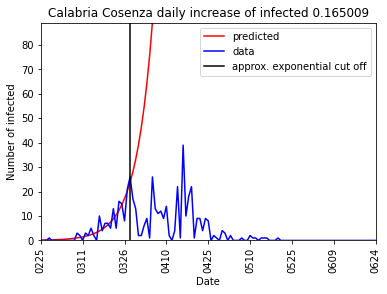

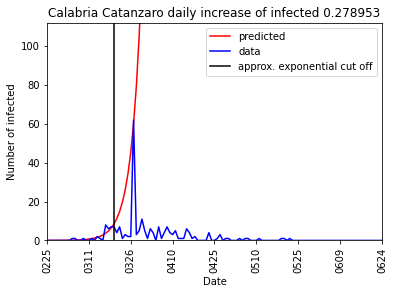

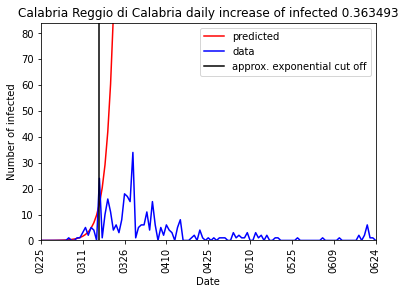

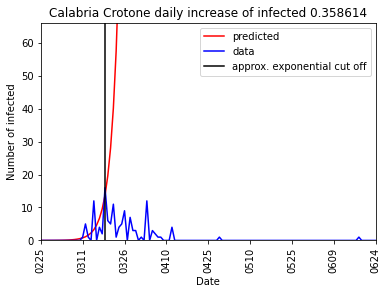

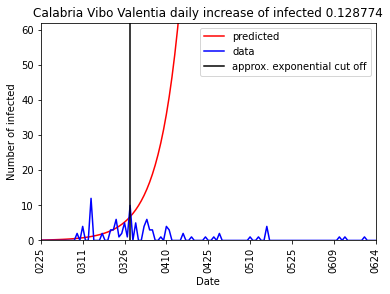

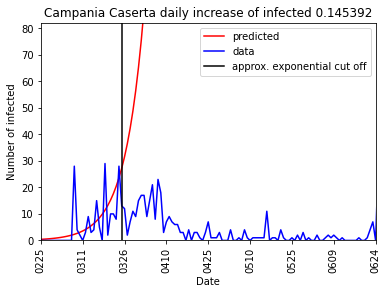

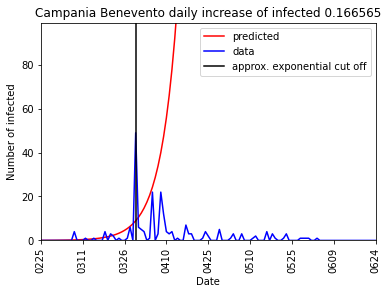

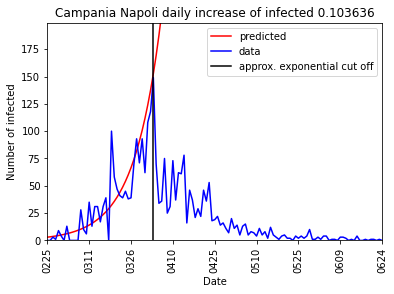

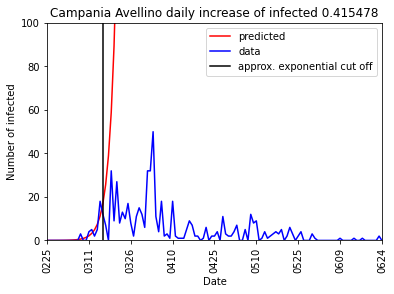

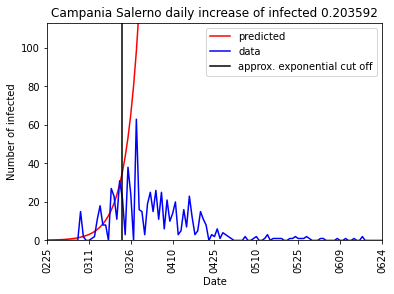

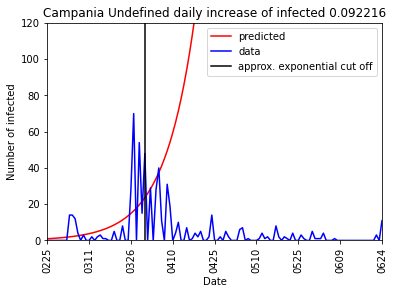

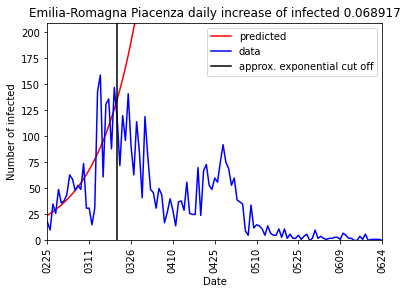

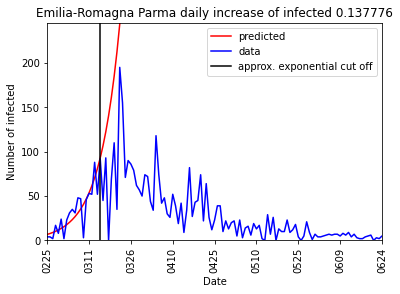

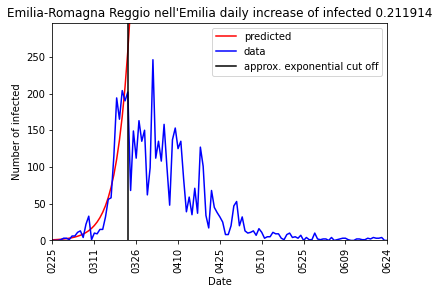

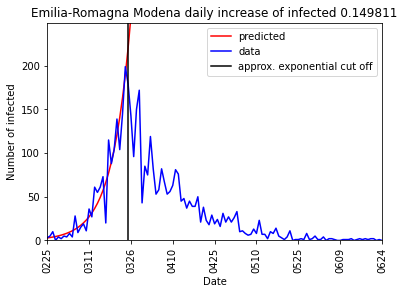

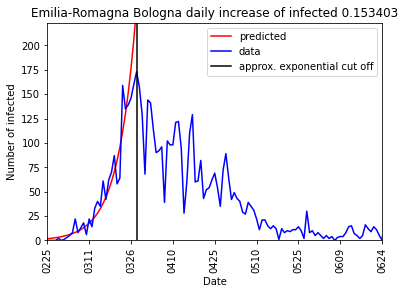

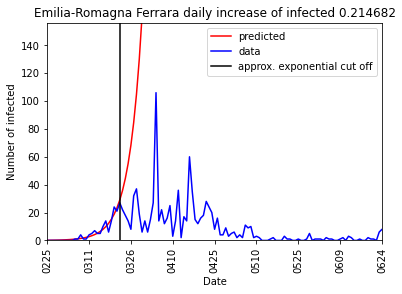

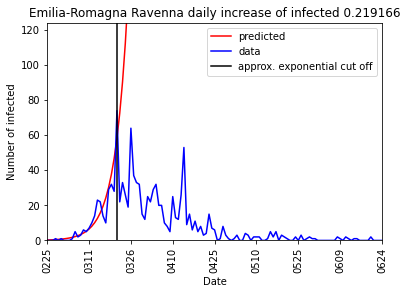

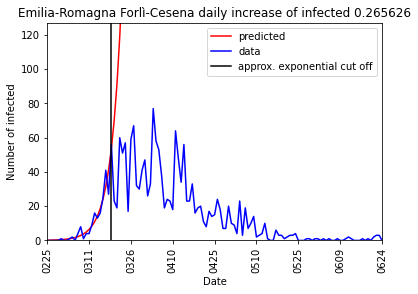

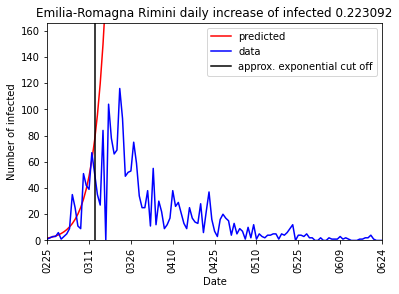

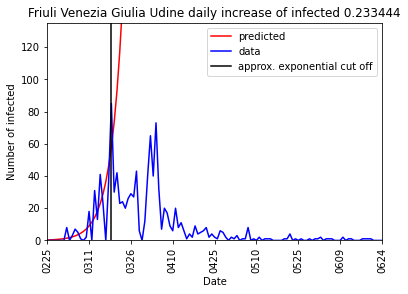

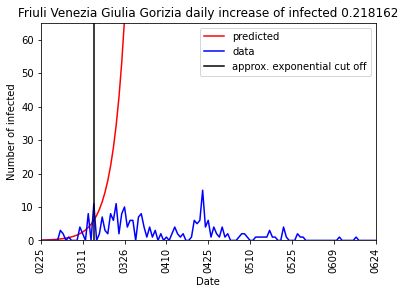

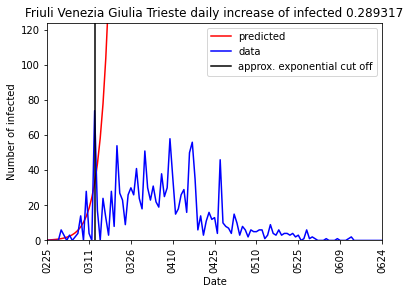

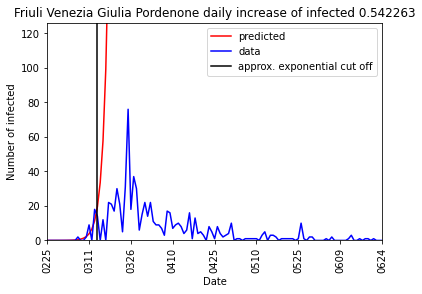

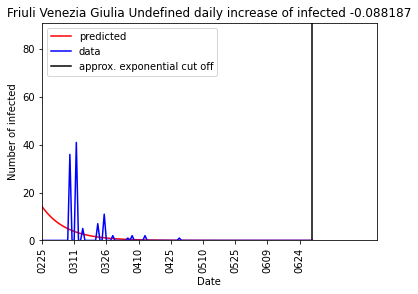

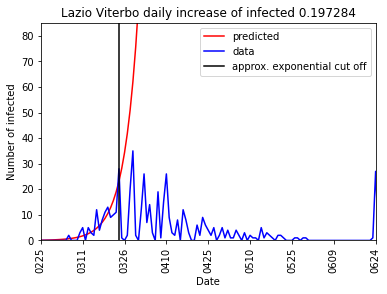

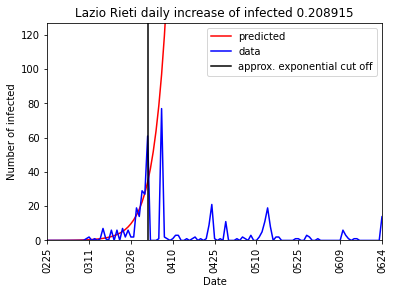

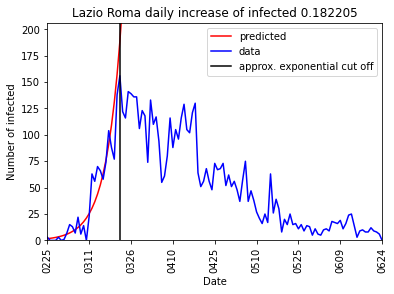

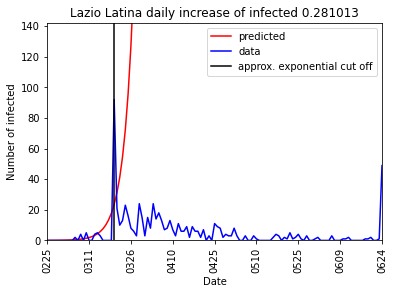

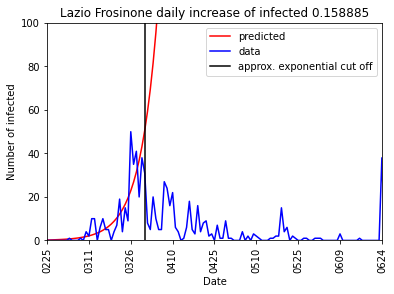

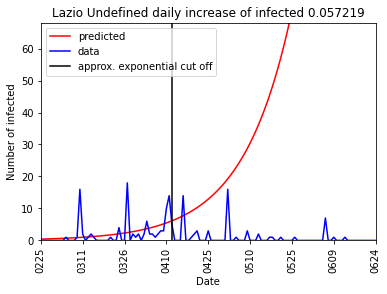

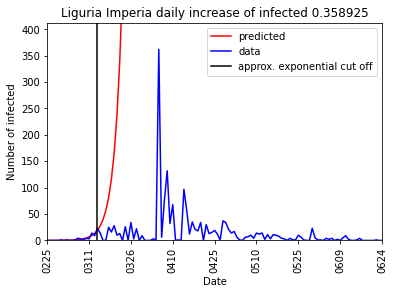

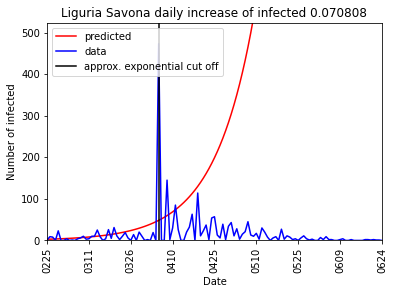

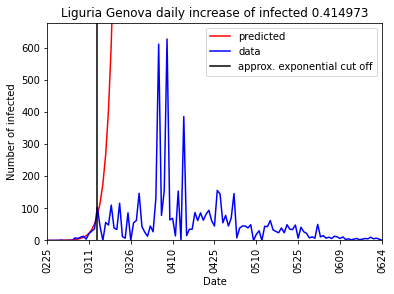

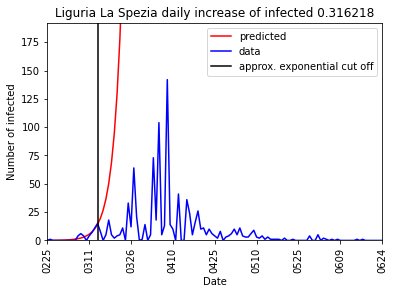

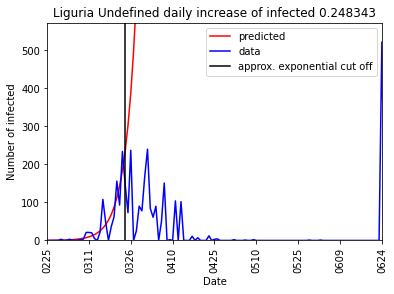

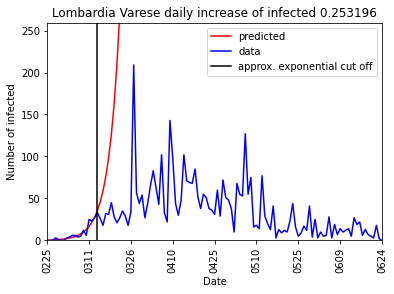

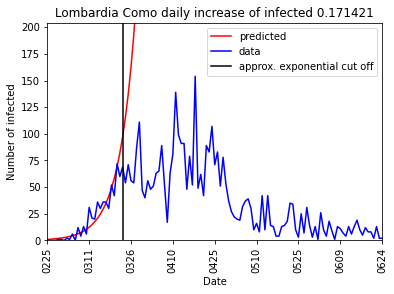

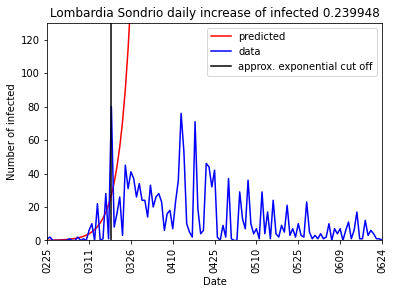

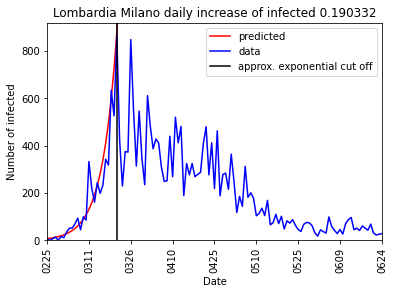

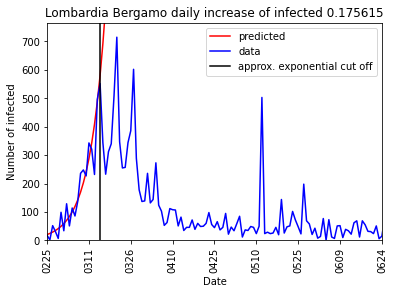

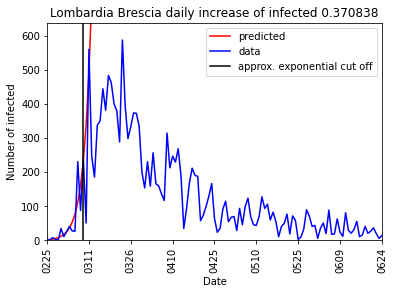

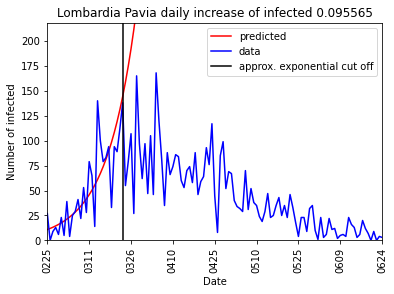

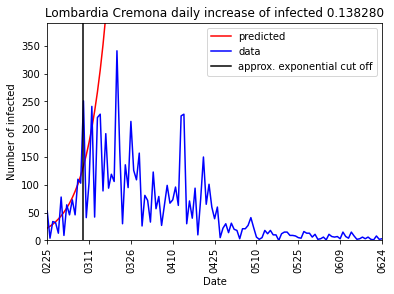

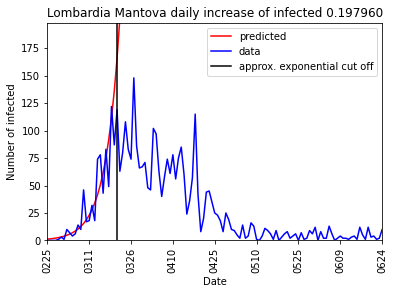

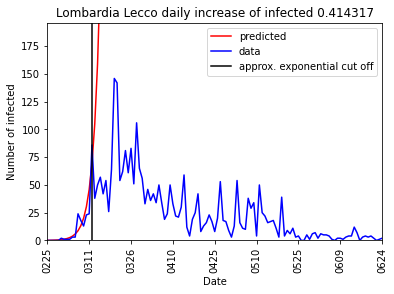

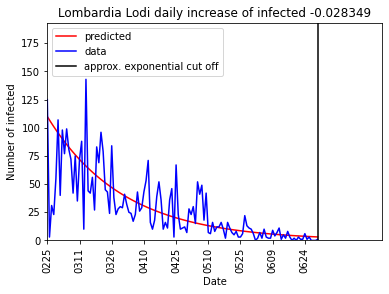

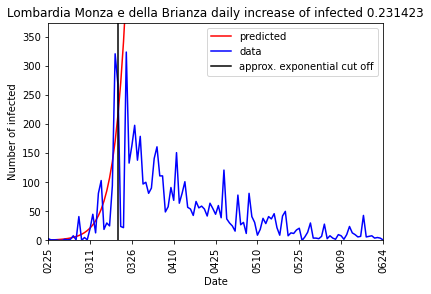

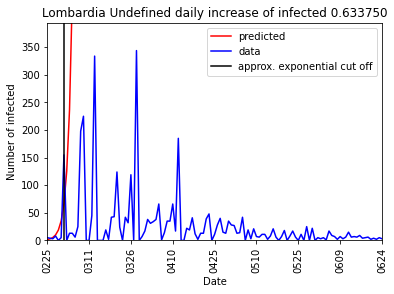

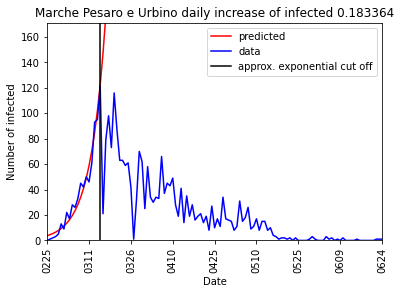

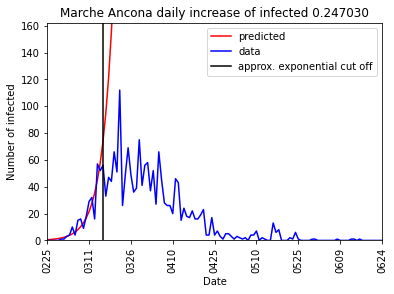

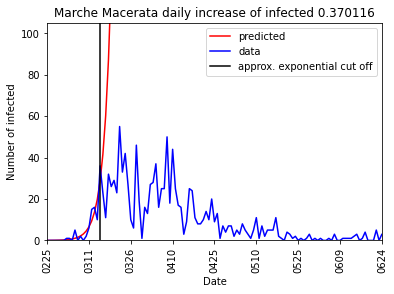

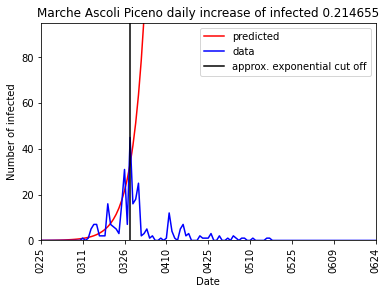

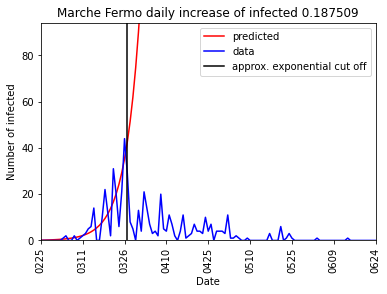

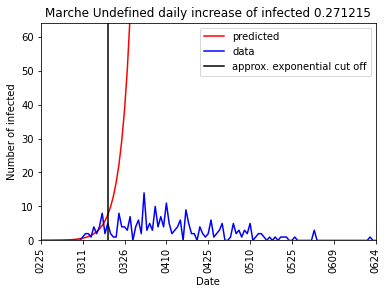

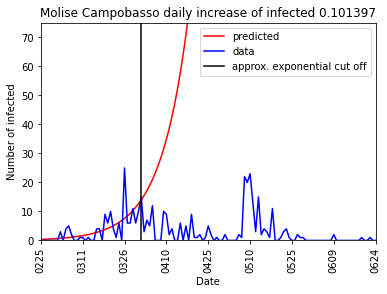

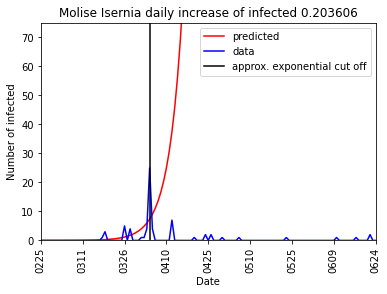

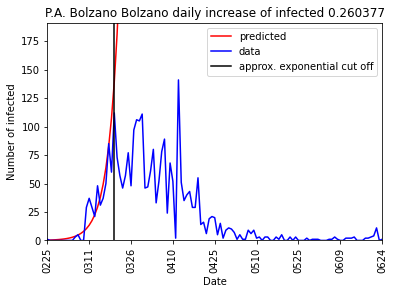

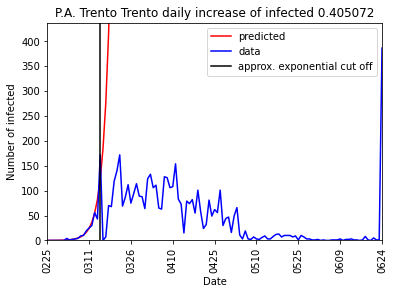

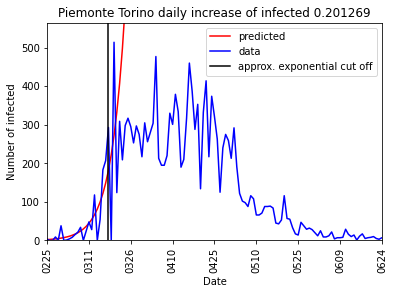

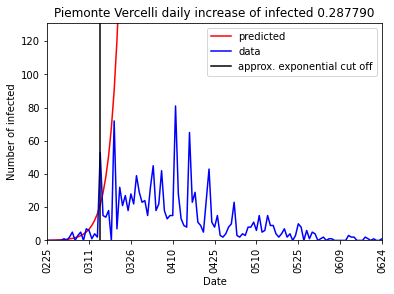

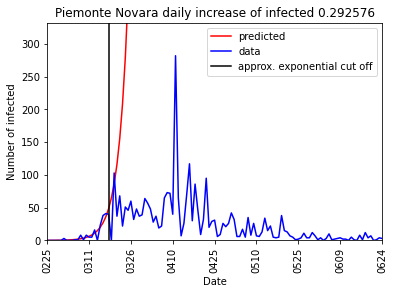

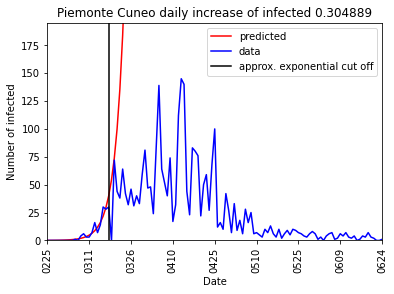

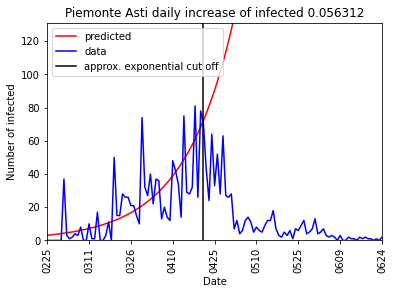

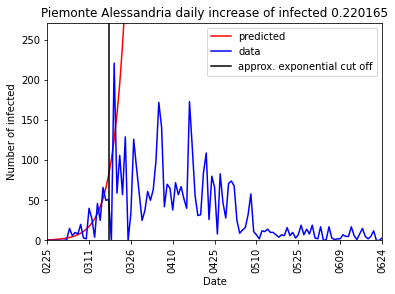

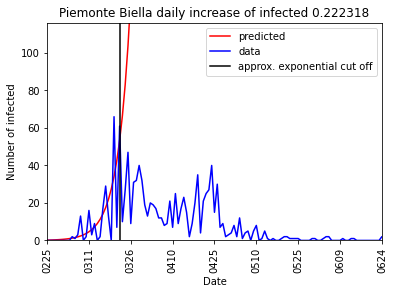

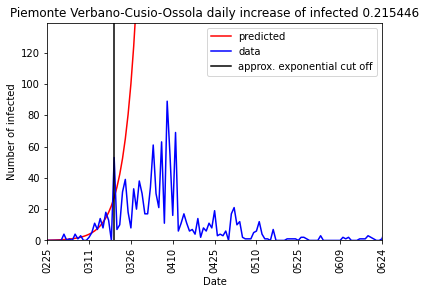

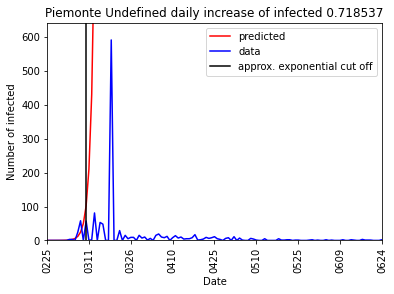

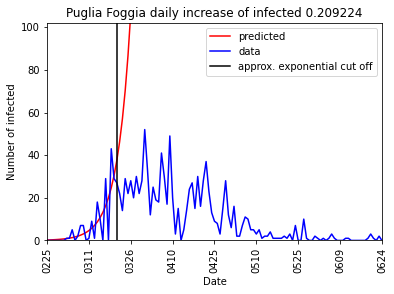

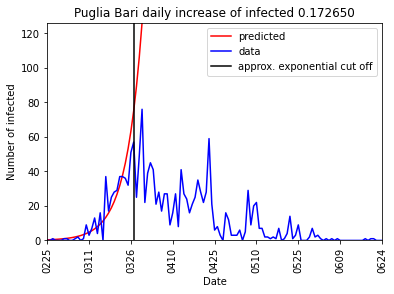

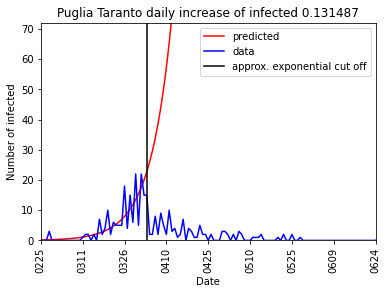

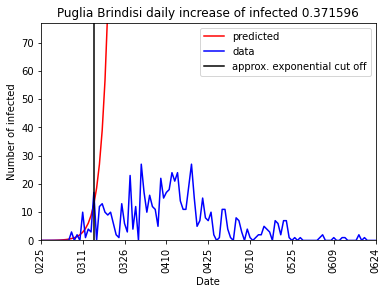

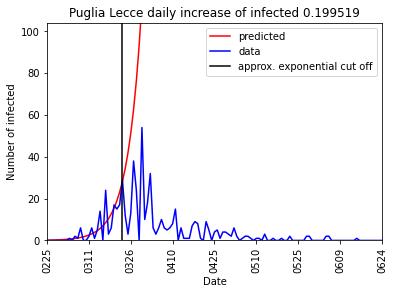

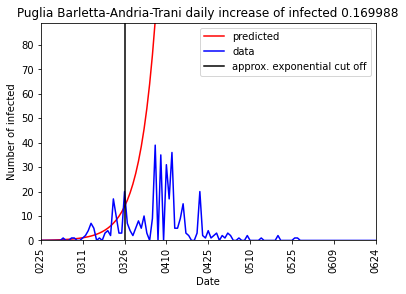

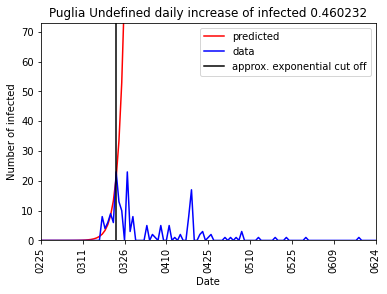

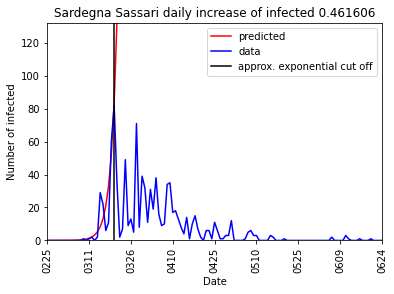

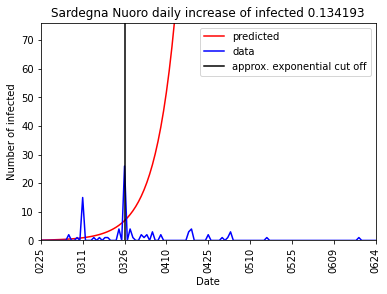

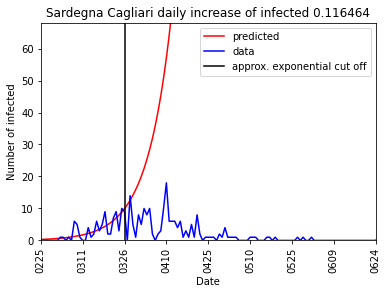

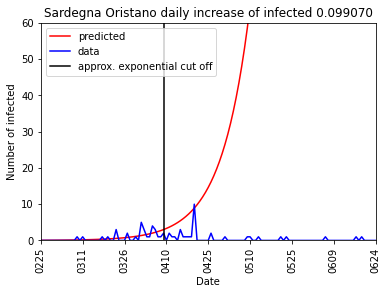

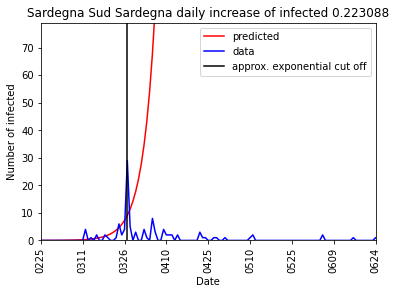

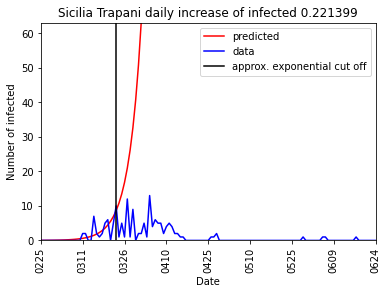

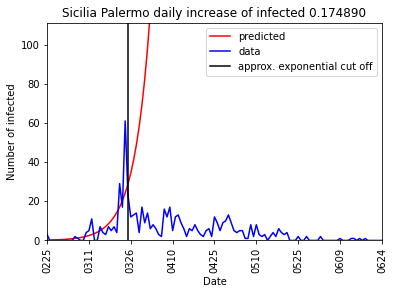

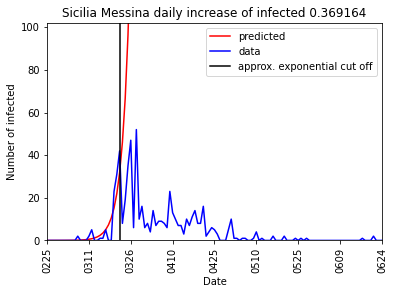

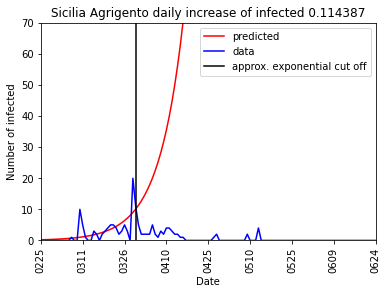

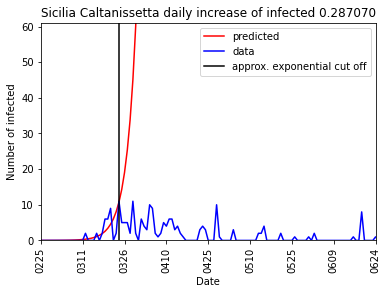

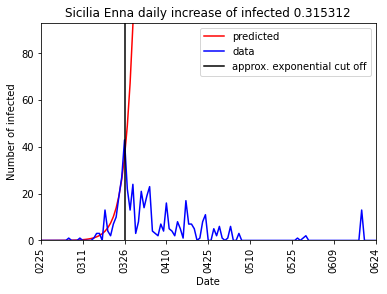

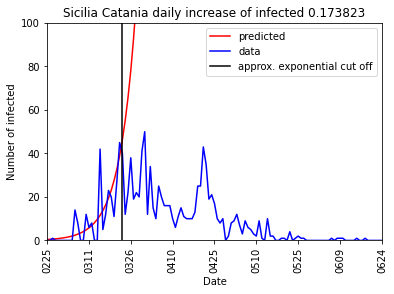

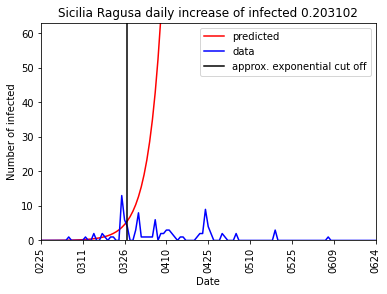

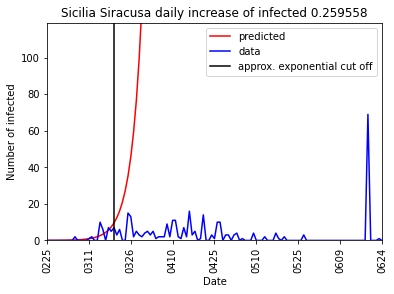

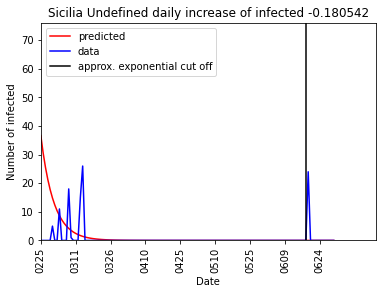

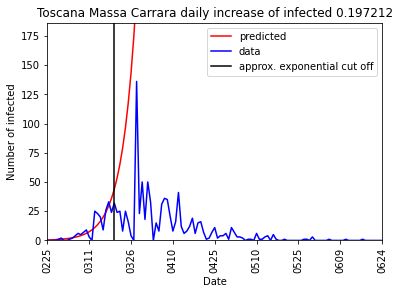

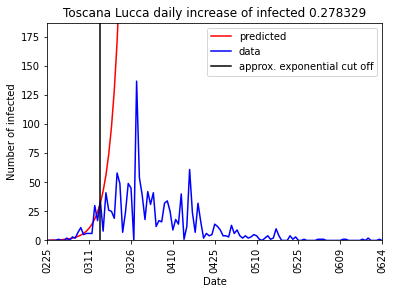

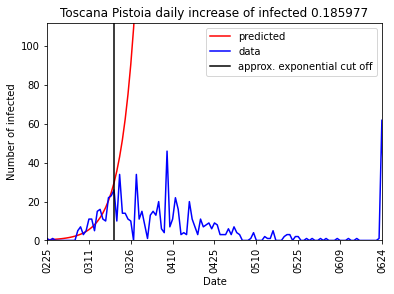

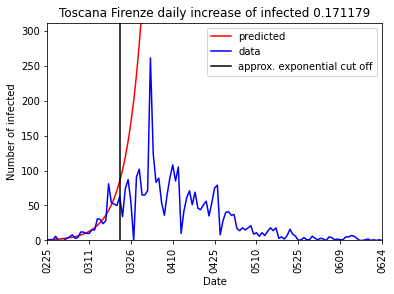

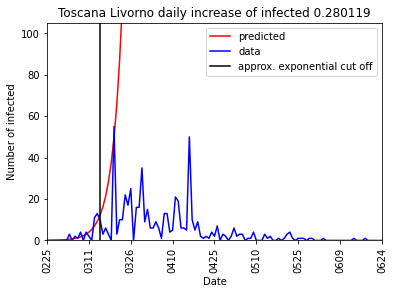

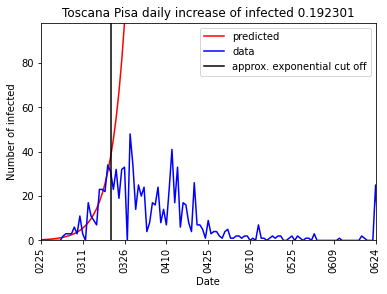

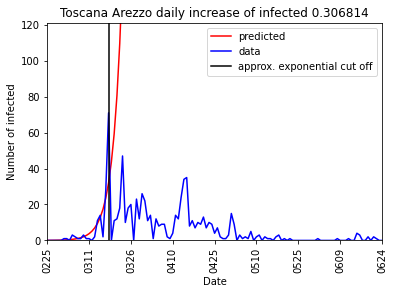

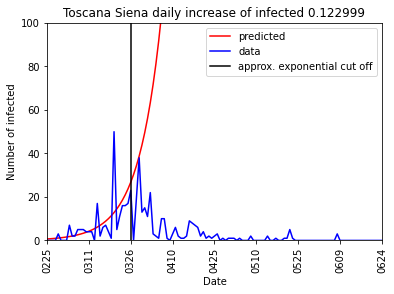

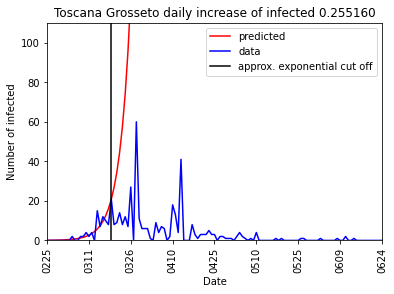

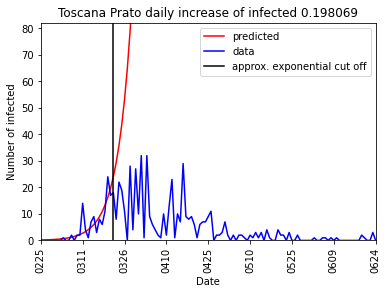

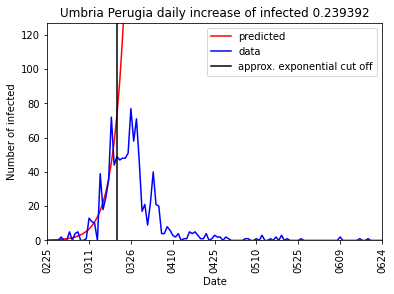

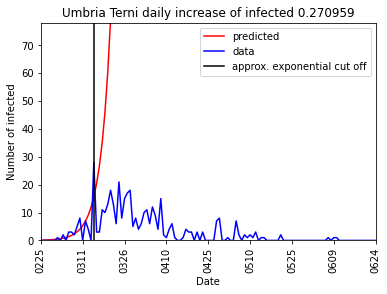

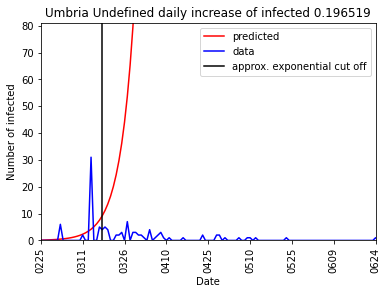

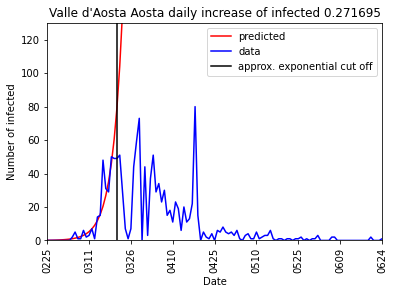

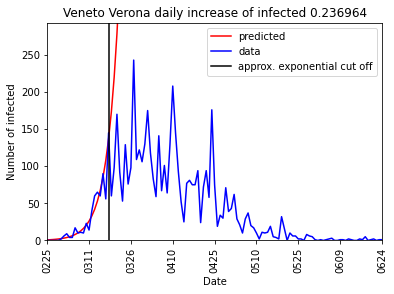

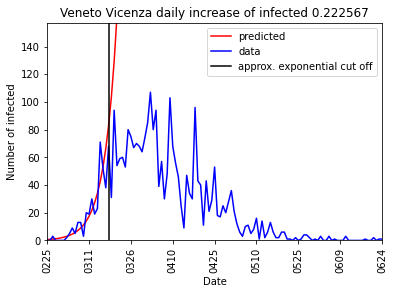

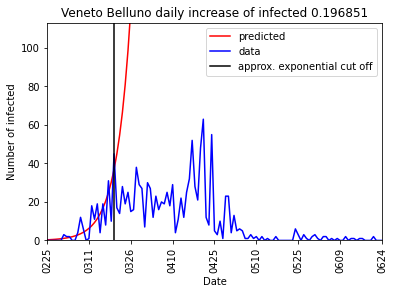

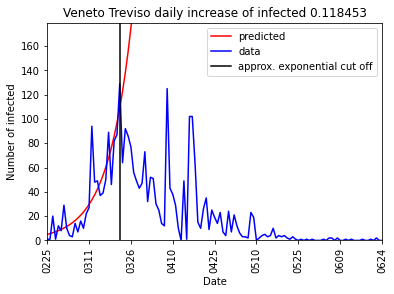

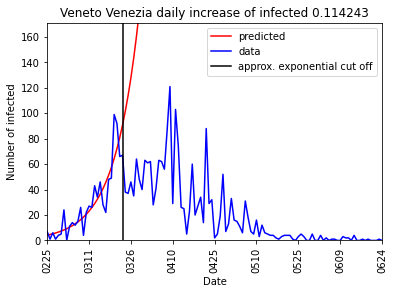

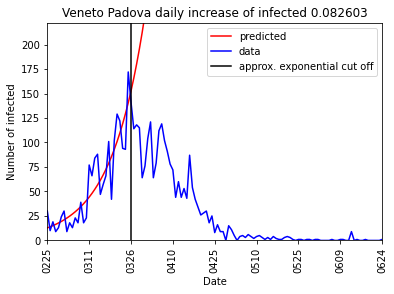

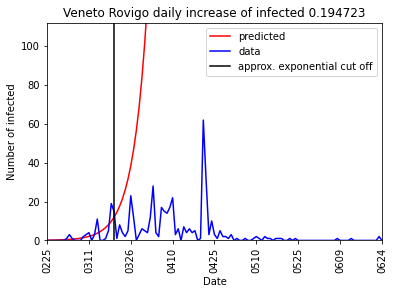

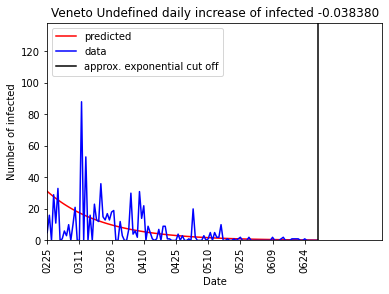

In [150]:
for p in p_i_results.index:
    start_date = pd.to_timedelta(provinces[p]["diff_time"][0],unit="D") + pd.Timestamp('1/1/2020')
    dates = pd.date_range(start=start_date,periods = len(provinces[p]["diff_time"]),freq="D")
    dates = dates.format(formatter=lambda x: x.strftime('%m%d'))
    dates = dates[0::15]
    
    xlim = provinces[p]["di_cases"].max() + 50
    
    plt.figure()
    plt.xlim((0,p_i_results["cut_offs"][p]+30))
    plt.ylim((0,xlim))
    plt.title(p+" daily increase of infected %f" % p_i_results.loc[p,"Growth Rate"])
    plt.plot(p_i_pred[p],color="red",label="predicted")
    plt.plot(provinces[p]["di_cases"],color = "blue",label="data")
    plt.axvline(x=p_i_results["cut_offs"][p],color="black",label="approx. exponential cut off")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Number of infected")
    plt.xticks(ticks = range(0,len(provinces[p]["di_cases"]),15),labels=dates,rotation=90)

In [124]:
# Spearman Corr
from scipy.stats import spearmanr
import pickle

with open("Italy_first_wave_growth_rates.pickle","rb") as f:
    italy = pickle.load(f)
p = italy["p"]
r = italy["r"]
n = italy["n"]

# arrival
# print(spearmanr(p['Growth Rate'],arrival_p[p.index],nan_policy='omit'))
# print(spearmanr(r['Growth Rate'],arrival_r[r.index],nan_policy='omit'))

# popu_den
p_popuden = pd.read_excel('italy_popu_den_provinces.xlsx')
r_popuden = pd.read_excel('italy_popu_den_regions.xlsx')
p_popuden.dropna(inplace=True)
p_popuden.index = p_popuden['Region'] + " " + p_popuden['Provinces']
# p_popuden.index = p_popuden.index.str.replace('e della','and')
p.index = p.index.str.replace(' di','')
p.index = p.index.str.replace('e della','and')
p.index = p.index.str.replace(' e ',' and ')
p_popuden.index = p_popuden.index.str.replace('Naples','Napoli')
p.index = p.index.str.replace('nell\'','')
p_popuden.index = p_popuden.index.str.replace('Friuli-Venezia','Friuli Venezia')
p_popuden.index = p_popuden.index.str.replace('Lombardy','Lombardia')
p_popuden.index = p_popuden.index.str.replace('Sicily','Sicilia')
p_popuden.index = p_popuden.index.str.replace('Piedmont','Piemonte')
p_popuden.index = p_popuden.index.str.replace('Sardinia','Sardegna')
p_popuden.index = p_popuden.index.str.replace('Tuscany','Toscana')
p_popuden.index = p_popuden.index.str.replace('Massa and Carrara','Massa Carrara')
p_popuden.index = p_popuden.index.str.replace('Syracuse', 'Siracusa')
p_popuden.index = p_popuden.index.str.replace('Turin', 'Torino')
p_popuden.index = p_popuden.index.str.replace('Mantua', 'Mantova')
p_popuden.index = p_popuden.index.str.replace('Milan', 'Milano')
p_popuden.index = p_popuden.index.str.replace('Rome', 'Roma')
p_popuden.index = p_popuden.index.str.replace('Genoa', 'Genova')
p_popuden.index = p_popuden.index.str.replace('South', 'Sud')
p_popuden.index = p_popuden.index.str.replace('Florence', 'Firenze')
p_popuden.index = p_popuden.index.str.replace('Venice', 'Venezia')
p_popuden.index = p_popuden.index.str.replace('Padua', 'Padova')
p_popuden.index = p_popuden.index.str.replace('Aosta Valley Aosta',"Valle d'Aosta Aosta")
p_popuden.index = p_popuden.index.str.replace('Apulia','Puglia')

# merge
p = p.merge(p_popuden,left_index=True,right_index=True,how="inner")
r = r.merge(r_popuden,left_index=True,right_on='Regions',how="inner")

print(spearmanr(p['Growth Rate'],p['popu_den'],nan_policy='omit'))
print(spearmanr(r['Growth Rate'],r['popu_den'],nan_policy='omit'))

SpearmanrResult(correlation=0.03526441835890799, pvalue=0.7209882647547703)
SpearmanrResult(correlation=-0.2545454545454546, pvalue=0.4500365768888285)
